## Variational Inference

The dataset required is small and is available preprocessed here:

- https://drive.google.com/drive/folders/1Tg_3SlKbdv0pDog6k2ys0J79e1-vgRyd?usp=sharing

In [1]:
import torch
import numpy as np
from gpytorch.optim import NGD
from torch.optim import Adam
from torch.nn import Parameter
from matplotlib import pyplot as plt
from os import path

from lafomo.datasets import P53Data
from lafomo.configuration import VariationalConfiguration
from lafomo.models import OrdinaryLFM, MultiOutputGP, generate_multioutput_rbf_gp
from lafomo.plot import Plotter, Colours
from lafomo.trainers import VariationalTrainer
from lafomo.utilities.data import p53_ground_truth

Let's start by importing our dataset...

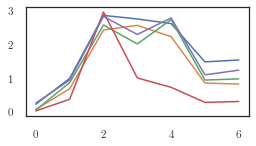

In [2]:
dataset = P53Data(replicate=0, data_dir='../../../data')
num_genes = 5
num_tfs = 1

plt.figure(figsize=(4, 2))
for i in range(5):
    plt.plot(dataset[i][1])

We use the ordinary differential equation (ODE):

`dy/dt = b + sf(t) - dy`

`f(t) ~ GP(0, k(t, t'))`

Since this is an ODE, we inherit from the `OrdinaryLFM` class.

In [3]:
from gpytorch.constraints import Positive
class TranscriptionLFM(OrdinaryLFM):
    def __init__(self, num_outputs, gp_model, config: VariationalConfiguration, **kwargs):
        super().__init__(num_outputs, gp_model, config, **kwargs)
        self.positivity = Positive()
        self.raw_decay = Parameter(0.1 + torch.rand(torch.Size([self.num_outputs, 1]), dtype=torch.float64))
        self.raw_basal = Parameter(torch.rand(torch.Size([self.num_outputs, 1]), dtype=torch.float64))
        self.raw_sensitivity = Parameter(0.2 + torch.rand(torch.Size([self.num_outputs, 1]), dtype=torch.float64))

    @property
    def decay_rate(self):
        return self.positivity.transform(self.raw_decay)

    @decay_rate.setter
    def decay_rate(self, value):
        self.raw_decay = self.positivity.inverse_transform(value)

    @property
    def basal_rate(self):
        return self.positivity.transform(self.raw_basal)

    @basal_rate.setter
    def basal_rate(self, value):
        self.raw_basal = self.positivity.inverse_transform(value)

    @property
    def sensitivity(self):
        return self.positivity.transform(self.raw_sensitivity)

    @sensitivity.setter
    def sensitivity(self, value):
        self.raw_sensitivity = self.decay_constraint.inverse_transform(value)

    def initial_state(self):
        return self.basal_rate / self.decay_rate

    def odefunc(self, t, h):
        """h is of shape (num_samples, num_outputs, 1)"""
        self.nfe += 1
        # if (self.nfe % 100) == 0:
        #     print(t)

        f = self.f[:, :, self.t_index].unsqueeze(2)

        h = self.basal_rate + self.sensitivity * f - self.decay_rate * h
        if t > self.last_t:
            self.t_index += 1
        self.last_t = t
        return h

In [4]:
config = VariationalConfiguration(
    preprocessing_variance=dataset.variance,
    num_samples=80,
    initial_conditions=False
)

num_inducing = 12  # (I x m x 1)
inducing_points = torch.linspace(0, 12, num_inducing).repeat(num_tfs, 1).view(num_tfs, num_inducing, 1)
t_predict = torch.linspace(0, 14, 80, dtype=torch.float32)
step_size = 5e-1
num_training = dataset.m_observed.shape[-1]
use_natural = True
gp_model = generate_multioutput_rbf_gp(num_tfs, inducing_points, gp_kwargs=dict(natural=use_natural))

lfm = TranscriptionLFM(num_genes, gp_model, config, num_training_points=num_training)
plotter = Plotter(lfm, dataset.gene_names, style='seaborn')

In [5]:
class P53ConstrainedTrainer(VariationalTrainer):
    def after_epoch(self):
        with torch.no_grad():
            sens = torch.tensor(1.)
            dec = torch.tensor(0.8)
            self.lfm.raw_sensitivity[3] = self.lfm.positivity.inverse_transform(sens)
            self.lfm.raw_decay[3] = self.lfm.positivity.inverse_transform(dec)
        super().after_epoch()

track_parameters = [
    'raw_basal',
    'raw_decay',
    'raw_sensitivity',
    'gp_model.covar_module.raw_lengthscale',
]
if use_natural:
    variational_optimizer = NGD(lfm.variational_parameters(), num_data=num_training, lr=0.1)
    parameter_optimizer = Adam(lfm.nonvariational_parameters(), lr=0.02)
    optimizers = [variational_optimizer, parameter_optimizer]
else:
    optimizers = [Adam(lfm.parameters(), lr=0.03)]
trainer = P53ConstrainedTrainer(lfm, optimizers, dataset, track_parameters=track_parameters)

### Outputs prior to training:

Text(0.5, 1.0, 'Latent')

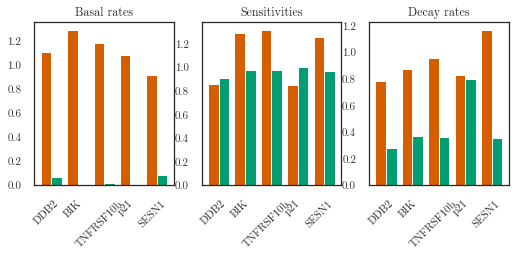

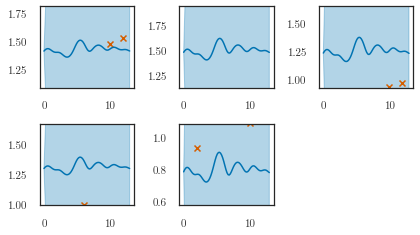

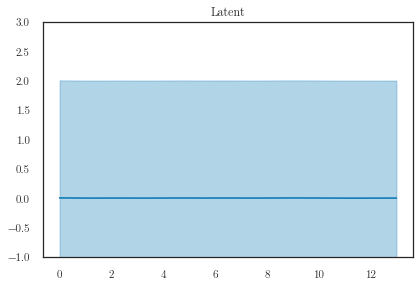

In [6]:
labels = ['Basal rates', 'Sensitivities', 'Decay rates']
kinetics = list()
for key in ['raw_basal', 'raw_sensitivity', 'raw_decay']:
    kinetics.append(
        lfm.positivity.transform(trainer.parameter_trace[key][-1].squeeze()).numpy())

plotter.plot_double_bar(kinetics, labels, p53_ground_truth())
q_m = lfm.predict_m(t_predict, step_size=1e-1)
q_f = lfm.predict_f(t_predict)

plotter.plot_gp(q_m, t_predict, replicate=0,
                t_scatter=dataset.t_observed,
                y_scatter=dataset.m_observed, num_samples=0)
plotter.plot_gp(q_f, t_predict, ylim=(-1, 3))
plt.title('Latent')


In [19]:
lfm.train()
step_size = 5e-1
trainer.train(400, report_interval=10, step_size=step_size)

Epoch 201/600 - Loss: 1.86 (-0.06 1.93) kernel: [[[0.96505964]]]
Epoch 211/600 - Loss: 1.68 (-0.33 2.01) kernel: [[[0.9695599]]]
Epoch 221/600 - Loss: 1.62 (-0.45 2.06) kernel: [[[0.96489483]]]
Epoch 231/600 - Loss: 1.54 (-0.58 2.11) kernel: [[[0.9734715]]]
Epoch 241/600 - Loss: 1.42 (-0.73 2.15) kernel: [[[0.98021686]]]
Epoch 251/600 - Loss: 1.39 (-0.79 2.18) kernel: [[[0.98585755]]]
Epoch 261/600 - Loss: 1.34 (-0.88 2.21) kernel: [[[0.99215156]]]
Epoch 271/600 - Loss: 1.29 (-0.94 2.23) kernel: [[[0.99823457]]]
Epoch 281/600 - Loss: 1.29 (-0.96 2.25) kernel: [[[0.99499804]]]
Epoch 291/600 - Loss: 1.19 (-1.08 2.27) kernel: [[[0.9992881]]]
Epoch 301/600 - Loss: 1.22 (-1.07 2.29) kernel: [[[1.0008785]]]
Epoch 311/600 - Loss: 1.28 (-1.02 2.30) kernel: [[[1.011957]]]
Epoch 321/600 - Loss: 1.21 (-1.11 2.32) kernel: [[[1.0143492]]]
Epoch 331/600 - Loss: 1.23 (-1.08 2.31) kernel: [[[1.0137051]]]
Epoch 341/600 - Loss: 1.26 (-1.06 2.32) kernel: [[[1.0174444]]]
Epoch 351/600 - Loss: 1.19 (-1.14 

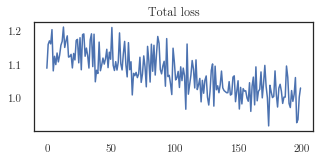

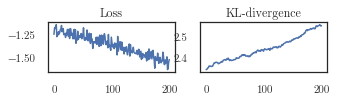

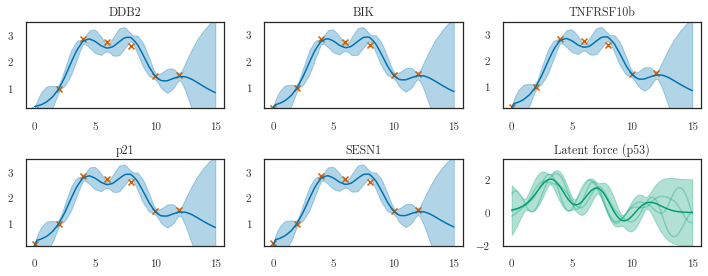

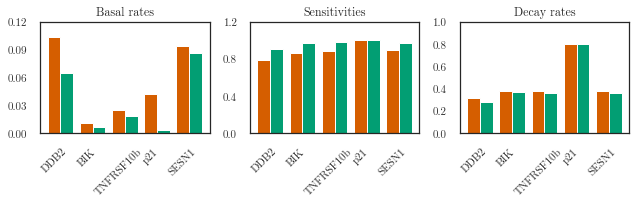

In [23]:
tight_kwargs = dict(bbox_inches='tight', pad_inches=0)
t_predict = torch.linspace(0, 15, 80, dtype=torch.float32)

lfm.eval()
q_m = lfm.predict_m(t_predict, step_size=step_size)
q_f = lfm.predict_f(t_predict)

plotter.plot_losses(trainer, last_x=200)
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 4))

row = 0
col = 0
for i in range(num_genes):
    if i == 3:
        row += 1
        col = 0
    ax = axes[row, col]
    plotter.plot_gp(q_m, t_predict, replicate=0, ax=ax,
                    color=Colours.line_color, shade_color=Colours.shade_color,
                    t_scatter=dataset.t_observed, y_scatter=dataset.m_observed, num_samples=0)
    col += 1
    ax.set_title(dataset.gene_names[i])
plotter.plot_gp(q_f, t_predict, ax=axes[1, 2],
                ylim=(-2, 3.2),
                num_samples=3,
                color=Colours.line2_color,
                shade_color=Colours.shade2_color)
axes[1, 2].set_title('Latent force (p53)')
plt.savefig('./combined.pdf', **tight_kwargs)

labels = ['Basal rates', 'Sensitivities', 'Decay rates']
kinetics = list()
for key in ['raw_basal', 'raw_sensitivity', 'raw_decay']:
    kinetics.append(
        lfm.positivity.transform(trainer.parameter_trace[key][-1].squeeze()).numpy())

plotter.plot_double_bar(kinetics, labels, p53_ground_truth(),
                        figsize=(9, 3),
                        yticks=[
                            np.linspace(0, 0.12, 5),
                            np.linspace(0, 1.2, 4),
                            np.arange(0, 1.1, 0.2),
                        ])
plt.tight_layout()
plt.savefig('./kinetics.pdf', **tight_kwargs)

In [ ]:
 # key in ['basal_rate', 'sensitivity', 'decay_rate']:
plt.plot(lfm.positivity.transform(torch.stack(trainer.parameter_trace['raw_basal'])[:, 3]))
plt.tight_layout()

In [ ]:
print(lfm.basal_rate)